# Electrode State of Health

This notebook demonstrates some utilities to work with electrode State of Health (also sometimes called electrode stoichiometry), using the algorithm from Mohtat et al [1]

[1] Mohtat, P., Lee, S., Siegel, J. B., & Stefanopoulou, A. G. (2019). Towards better estimability of electrode-specific state of health: Decoding the cell expansion. Journal of Power Sources, 427, 101-111.

In [1]:
%pip install pybamm -q # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


## Create and solve model

In [2]:
spm = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment([
    "Charge at 1C until 4.2V", 
    "Hold at 4.2V until C/50",
    "Discharge at 1C until 2.8V",
    "Hold at 2.8V until C/50",
])
parameter_values = pybamm.ParameterValues("Mohtat2020")

sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()
spm_sol.plot([
    "Terminal voltage [V]", 
    "Current [A]", 
    "Negative electrode SOC",
    "Positive electrode SOC",
])

interactive(children=(FloatSlider(value=0.0, description='t', max=2.3248422253249537, step=0.02324842225324953…

## Solve for electrode SOH variables

Given a total amount of lithium, $n_{Li}$, electrode capacities, $C_n$ and $C_p$, and voltage limits, $V_{min}$ and $V_{max}$, we can solve for the min and max electrode SOCs, $x_0$, $x_{100}$, $y_0$, and $y_{100}$,  and the cell capacity, $C$, using the algorithm from Mohtat et al [1].
First, we find $x_{100}$ and $y_{100}$ using
$$
\begin{align}
n_{Li} &= \frac{3600}{F}(y_{100}C_p + x_{100}C_n),
\\
V_{max} &= U_p(y_{100}) - U_n(x_{100}).
\end{align}
$$
Then, we find $C$ using
$$
\begin{align}
V_{min} &= U_p(y_{0}) - U_n(x_{0})
\\
&= U_p\left(y_{100} + \frac{C}{C_p}\right) - U_n\left(x_{100} - \frac{C}{C_n}\right)
\end{align}
$$
Finally, $x_0$ and $y_0$ are simply defined as
$$
\begin{align}
x_0 &= x_{100} - \frac{C}{C_n},
\\
y_0 &= y_{100} + \frac{C}{C_p}.
\end{align}
$$
We implement this in pybamm as an algebraic model.

In [3]:
param = pybamm.LithiumIonParameters()

Vmin = 2.8
Vmax = 4.2
Cn = parameter_values.evaluate(param.n.cap_init)
Cp = parameter_values.evaluate(param.p.cap_init)
n_Li = parameter_values.evaluate(param.n_Li_particles_init)

Un = param.n.U_dimensional
Up = param.p.U_dimensional
T_ref = param.T_ref

In [4]:
# First we solve for x_100 and y_100

model = pybamm.BaseModel()

x_100 = pybamm.Variable("x_100")
y_100 = (n_Li * param.F / 3600 - x_100 * Cn) / Cp

y_100_min = 1e-10

x_100_upper_limit = ((n_Li * param.F) / 3600 - y_100_min*Cp)/Cn

if not isinstance(x_100_upper_limit, float):
    x_100_upper_limit = x_100_upper_limit.value
    
x_100_upper_limit = min(x_100_upper_limit, 1-1e-10)


Vmax_init = parameter_values.evaluate(Up(y_100_min, T_ref)) - parameter_values.evaluate(Un(x_100_upper_limit, T_ref))
Vmin_init = parameter_values.evaluate(Up(y_100_min + 1, T_ref)) - parameter_values.evaluate(Un(x_100_upper_limit - Cp/Cn, T_ref))


if isinstance(parameter_values["Positive electrode OCP [V]"], tuple):
    # if data is provided for the Positive (or Negative) electrode OCP [V] 
    # the intial conditions must be within the bounds of this data to prevent extrapolation errors
    y_100_min = np.min(parameter_values["Positive electrode OCP [V]"][1][1])
    x_100_upper_limit = (n_Li * pybamm.constants.F.value / 3600 - y_100_min * Cp) / Cn

    V_lower_bound = min(parameter_values["Positive electrode OCP [V]"][1][1]) - parameter_values["Negative electrode OCP [V]"](x_100_upper_limit).evaluate()
    V_upper_bound = max(parameter_values["Positive electrode OCP [V]"][1][1]) - parameter_values["Negative electrode OCP [V]"](x_100_upper_limit).evaluate()

    if Vmin_init[0][0] < V_lower_bound:
        raise(ValueError("Initial voltage is outside bounds of OCP data in parameter set. Revise initial values."))

    if Vmax_init[0][0] > V_upper_bound:
        raise(ValueError("Initial voltage is outside bounds of OCP data in parameter set. Revise initial values."))


model.algebraic = {
    x_100: Up(y_100, T_ref) - Un(x_100, T_ref) - Vmax + 1e5*(y_100<0) + 1e5*(x_100>1),
}
    
model.initial_conditions = {
    x_100: x_100_upper_limit
}

model.variables = {
    "x_100": x_100,
    "y_100": y_100
}


sim = pybamm.Simulation(model, parameter_values=parameter_values)

sol = sim.solve([0])

x_100 = sol["x_100"].data[0]
y_100 = sol["y_100"].data[0]

for var in ["x_100", "y_100"]:
    print(var, ":", sol[var].data[0])

# Based on the calculated values for x_100 and y_100 we solve for C
model = pybamm.BaseModel()

C = pybamm.Variable("C")
x_0 = x_100 - C/Cn
y_0 = y_100 + C/Cp

model.algebraic = {
    C: Up(y_0, T_ref) - Un(x_0, T_ref) - Vmin
}

model.initial_conditions = {C: pybamm.minimum(Cn * x_100 - 0.1, param.Q)}

model.variables = {
    "C": C,
    "x_0": x_0,
    "y_0": y_0,
}

sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve([0])


for var in ["C", "x_0", "y_0"]:
    print(var, ":", sol[var].data[0])

x_100 : 0.8333742766485523
y_100 : 0.03354554691530909
C : 4.968932681948703
x_0 : 0.0015118456450780027
y_0 : 0.8908948800910447


This is implemented in PyBaMM as the `ElectrodeSOHx100` and `ElectrodeSOHx0` models

In [5]:
x100_model = pybamm.lithium_ion.ElectrodeSOHx100()
C_model = pybamm.lithium_ion.ElectrodeSOHx0()

x100_sim = pybamm.Simulation(x100_model, parameter_values=parameter_values)
C_sim = pybamm.Simulation(C_model, parameter_values=parameter_values)

inputs={ "V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li}

esoh_sol = pybamm.lithium_ion.solve_electrode_soh(x100_sim, C_sim, inputs)

for var in ["x_100", "y_100", "C", "x_0", "y_0"]:
    print(var, ":", esoh_sol[var].data[0])

x_100 : 0.8333742762029195
y_100 : 0.0335455473745956
C : 4.968932679279886
x_0 : 0.0015118456462390934
y_0 : 0.8908948800898482


## Check against simulations

Plotting the SPM simulations against the eSOH calculations validates the min/max stoichiometry calculations

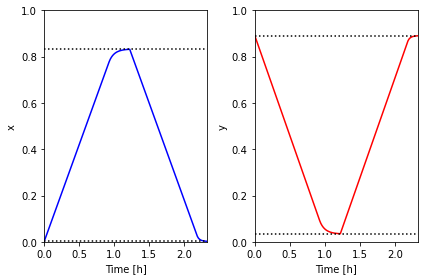

In [6]:
t = spm_sol["Time [h]"].data
x_spm = spm_sol["Negative electrode SOC"].data
y_spm = spm_sol["Positive electrode SOC"].data

x_0 = esoh_sol["x_0"].data * np.ones_like(t)
y_0 = esoh_sol["y_0"].data * np.ones_like(t)
x_100 = esoh_sol["x_100"].data * np.ones_like(t)
y_100 = esoh_sol["y_100"].data * np.ones_like(t)

fig, axes = plt.subplots(1,2)

axes[0].plot(t, x_spm, "b")
axes[0].plot(t, x_0, "k:")
axes[0].plot(t, x_100, "k:")
axes[0].set_ylabel("x")
    
axes[1].plot(t, y_spm, "r")
axes[1].plot(t, y_0, "k:")
axes[1].plot(t, y_100, "k:")
axes[1].set_ylabel("y")
    
for k in range(2):
    axes[k].set_xlim([t[0],t[-1]])
    axes[k].set_ylim([0,1])    
    axes[k].set_xlabel("Time [h]")
    
fig.tight_layout()


## References

The relevant papers for this notebook are:

In [7]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Peyman Mohtat, Suhak Lee, Jason B Siegel, and Anna G Stefanopoulou. Towards better estimability of electrode-specific state of health: decoding the cell expansion. Journal of Power Sources, 427:101–111, 201